# CNN (Convolutional Neural Networks) for Magic Set Recognition

In [2]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cv2

from keras import applications
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, Dense, Flatten, BatchNormalization
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [3]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
a = cv2.imread('card_ml/train/dom/00d89839-60d7-4de2-a78a-1afdcc21c053.jpg')
a.shape

(680, 488, 3)

In [5]:
factor=4
print(a.shape[0]/factor)
print(a.shape[1]/factor)

170.0
122.0


In [6]:
batch_size = 32

img_size = (250,250)
input_shape = (250,250,3)

train_dir = "card_ml/train/"
val_dir = "card_ml/validation/"
test_dir = "card_ml/test"

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   fill_mode = "constant",
                                   zoom_range = 0.2,
                                   width_shift_range = 0.05,
                                   height_shift_range=0.05,
                                   rotation_range=10)

val_datagen = ImageDataGenerator(rescale=1/255.,
                                   fill_mode = "constant",
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10)

test_datagen = ImageDataGenerator(rescale=1/255.,
                                   fill_mode = "constant",
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10)

train_generator = train_datagen.flow_from_directory(
         train_dir,
         target_size = img_size,
         batch_size = batch_size,
         class_mode = "categorical")

val_generator = val_datagen.flow_from_directory(
         val_dir,
         target_size = img_size,
         batch_size = batch_size,
         class_mode = "categorical")

test_generator = test_datagen.flow_from_directory(
         test_dir,
         target_size = img_size,
         batch_size = batch_size,
         class_mode = "categorical")

Found 1183 images belonging to 5 classes.
Found 153 images belonging to 5 classes.
Found 354 images belonging to 5 classes.


In [7]:
train_generator.class_indices

{'dom': 0, 'grn': 1, 'm19': 2, 'rix': 3, 'xln': 4}

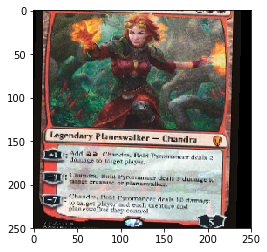

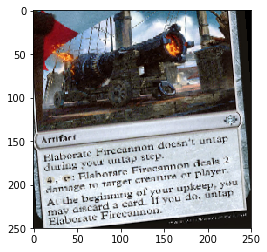

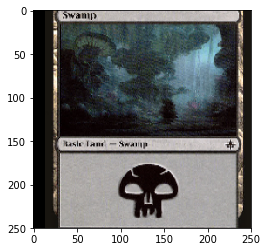

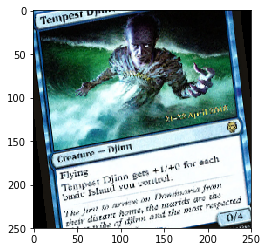

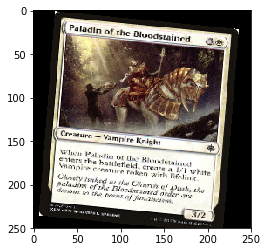

In [8]:
for i,batch in enumerate(train_generator):
    plt.imshow(batch[0][0])
    plt.show()
    if i==4:
        break

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       147584    
__________

In [10]:
epochs = 1000

opt = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=30, mode='auto')
checkpoint = ModelCheckpoint('magic_model_best.h5', monitor='val_loss', verbose=10, save_best_only=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=50,
                              verbose=2,
                              callbacks=[earlystop,checkpoint])


Epoch 1/1000
 - 61s - loss: 1.5912 - acc: 0.2540 - val_loss: 1.5907 - val_acc: 0.2876

Epoch 00001: val_loss improved from inf to 1.59069, saving model to magic_model_best.h5
Epoch 2/1000
 - 60s - loss: 1.4726 - acc: 0.3685 - val_loss: 1.4370 - val_acc: 0.3725

Epoch 00002: val_loss improved from 1.59069 to 1.43696, saving model to magic_model_best.h5
Epoch 3/1000
 - 63s - loss: 1.2194 - acc: 0.5282 - val_loss: 1.3057 - val_acc: 0.4444

Epoch 00003: val_loss improved from 1.43696 to 1.30574, saving model to magic_model_best.h5
Epoch 4/1000
 - 62s - loss: 1.0071 - acc: 0.6074 - val_loss: 1.3267 - val_acc: 0.4575

Epoch 00004: val_loss did not improve from 1.30574
Epoch 5/1000
 - 60s - loss: 0.8294 - acc: 0.6906 - val_loss: 0.9423 - val_acc: 0.6405

Epoch 00005: val_loss improved from 1.30574 to 0.94235, saving model to magic_model_best.h5
Epoch 6/1000
 - 63s - loss: 0.7375 - acc: 0.7201 - val_loss: 1.1032 - val_acc: 0.6144

Epoch 00006: val_loss did not improve from 0.94235
Epoch 7/1000

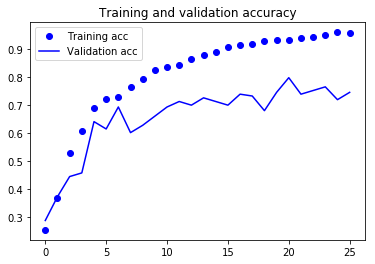

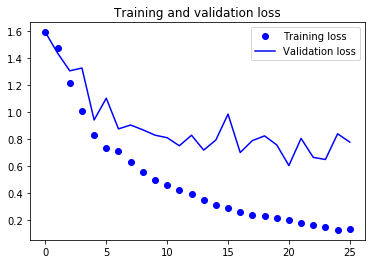

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 153 images belonging to 5 classes.
5/5 [==============================] - 3s 603ms/step
0.738562091503268
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        34
           1       0.70      0.72      0.71        29
           2       0.88      0.86      0.87        35
           3       0.59      0.70      0.64        23
           4       0.96      0.75      0.84        32

   micro avg       0.74      0.74      0.74       153
   macro avg       0.75      0.73      0.74       153
weighted avg       0.76      0.74      0.74       153



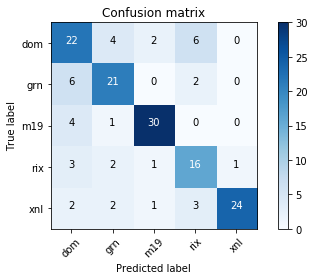

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from keras.models import load_model

m=load_model('magic_model_best.h5')

#val_datagen2 = ImageDataGenerator(rescale=1/255.)
v2_generator = val_datagen.flow_from_directory(
         val_dir,
         target_size = img_size,
         batch_size = batch_size,
         shuffle=False,
         class_mode = "categorical")

pred_proba = m.predict_generator(v2_generator, verbose=1)
y_pred = pred_proba.argmax(axis=1)
y_true = v2_generator.classes
#print(classification_report(y_val, y_pred))

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
labels = ['dom','grn','m19','rix','xnl']
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=labels,title='Confusion matrix')